# NASA Cloud-Based OPeNDAP Access and Subsetting - Daymet Data

*Author:  ORNL DAAC*
<br>
*Date: March 13, 2023*
<br>
*Contact for [ORNL DAAC](https://daac.ornl.gov/):  uso@daac.ornl.gov*

##### Keywords:  ORNL DAAC, Daymet, THREDDS, OPeNDAP, Earthdata, , `CMR API`, `pydap`, `xarray`

## Tutorial Overview

In this tutorial, we're interested in obtaining a **spatial** and **temporal subset** of gridded multidimentional (ie. netCDF) data using OPeNDAP.  We'll demonstrate how to programatically discover, access, and subset using Daymet daily data hosted from NASA's Earthdata Cloud as an example dataset. 

- **STEP 1: Setting Search and Subset Parameters:** Demonstrates how to use a shape file's bounding box coordinates to obtain `search` and `subsetting` parameters. 

- **STEP 2: Finding Data Files of Interest:**  Demonstrates how use spatial and temporal parameters to search NASA's Dataset Collections to discover Granules (files) of interest using `NASA's CMR API`. 

- **STEP 3: Subsetting Data:** Demonstrates how to subset from the North American Daymet dataset netCDF files using `pydap` to inspect data from the NASA Earthdata Cloud Hyrax `OPeNDAP` server.

Steps we'll explore: 
- Store a shape file's (polygon) bounding box parameters to use for searching and subsetting from the North American extent of Daymet Data
- Use the Daymet dataset **DOI** or the Daymet **shortname** and NASA's **Common Metadata Repository (CMR) API** to search for Daymet data within a spatial and temporal region of interest
- Build a **Request URL** to create a list of files that match our search criteria
- From Daymet data on the NASA Earthdata Cloud-based Hyrax **OPeNDAP Server** we will find, subset, and concatenate data as if it were stored locally
- **Download subsets** of data NASA Earthdata Cloud to a local computer
- **Clip** the subset to the polygon of interest

#### Daymet Data: NASA Earthdata
 - [NASA Earthdata Daymet Collections](https://search.earthdata.nasa.gov/portal/ornldaac/search?fpj=Daymet!Daymet!Daymet)

#### Daymet Data: ORNL DAAC 
- The [Daymet Website](https://daymet.ornl.gov) provides comprehensive information about and access methods for the Daymet datasets under the [Get Data](https://daymet.ornl.gov/getdata) tab. 

- Landing Page for [Daymet: Daily Surface Weather Data on a 1-km Grid for North America, Version 4 R1](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=2129).  
- Daymet V4 Daily Data dataset DOI **https://doi.org/10.3334/ORNLDAAC/2129**
<div class="alert alert-block alert-info">
Thornton, M.M., R. Shrestha, Y. Wei, P.E. Thornton, S-C. Kao, and B.E. Wilson. 2022. Daymet: Daily Surface Weather Data on a 1-km Grid for North America, Version 4 R1. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/2129
</div>



### Daymet Overview
<div class="alert alert-block alert-warning">

SKIP this section if you're familiar with Daymet:  The **[Daymet](https://daymet.ornl.gov/)** dataset provides gridded estimates of daily weather data interpolated and extrapoloated from ground-based surface weather observations.  Annual and monthly climatologies are also available.  The spatial resolution of the data is 1km x 1km and the daily data are distributed in a multidimensional, netCDF file format. Daymet data is available for continenal North America (na), with Hawaii (hi), and Puerto Rico (pr) as separate data files.

The Daymet daily North American files [Daymet: Daily Surface Weather Data on a 1-km Grid for North America, Version 4 R1](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=2129) are large and often a researcher needs a spatial or temporal subset of the data based on their region of interest. 


![title](images/Daymet_V4_Annual_Climatology_Fig1.png)

DAYMET Temporal Availability:

| Spatial Area    | Years                          
|:---------       |:---------------------------------------:|
| North America   | 1980 - present
| Hawaii          | 1980 - present
| Puerto Rico     | 1950 - present

DAYMET VARIABLES:

| Variable | Description (units)                           
|:---------|:---------------------------------------:|
| tmax     | Daily maximum 2-meter air temperature (°C)
| tmin     | Daily minimum 2-meter air temperature (°C)
| prcp     | Daily total precipitation (mm/day)
| srad     | Incident shortwave radiation flux density (W/m2)
| vp       | Water vapor pressure (Pa)
| swe      | Snow water equivalent (kg/m2)
| dayl     | Duration of the daylight period (seconds/day)

Daymet V4 Daily Data files (or granules) are distributed in netCDF4 format, and each file has one year's worth of data. Data files are organized by variables (dayl, prcp, tmin, tmax, srad, swe, vp) and regions (each for na, pr, hi).

The standard naming convention for a file is:  

- daymet_v4_daily_`area`_`variable`_`year`.nc
- daymet_v4_daily_na_tmax_2022.nc
</div>

----

## Tutorial Requirements
* Python 3.7 or higher
* geopandas and dependencies
* pydap
* xarray
* rasterio
* shapely

In [ ]:
#Running from pyenv, Conda, activate hyrax_daymet
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import pyproj
import datetime as dt 
from rasterio.features import Affine
from pydap.client import open_url
from pydap.cas.urs import setup_session
import xarray as xr
import rioxarray
import shapely
import rasterio
from shapely.geometry import mapping
import json

In [2]:
print("This Notebook was produced with the following versions")
print("geopanda version   : ", gpd.__version__)
print("pyproj version     : ", pyproj.__version__)
print("rioxarray version  : ", rioxarray.__version__)
print("xarray version     : ", xr.__version__)
print("shapely            : ", shapely.__version__)
print("rasterio           : ", rasterio.__version__)


This Notebook was produced with the following versions
geopanda version   :  0.10.2
pyproj version     :  3.3.0
rioxarray version  :  0.10.3
xarray version     :  2022.3.0
shapely            :  1.8.0
rasterio           :  1.2.10


In [3]:
!python --version

Python 3.9.12


***
***

## STEP 1.  Setting Search and Subset Parameters: Spatial Area and Time Range of Interest

## 1.1 Spatial: Search and Subset Parameters
You can always hard code subset parameters and if you do, you can skip to STEP 2 of this tutorial. 

Here we'll demonstrate how to use a polygon boundary file of California to get bounding box coordinates and how to use that for metadata discovery and spatial subsetting. Any polygon area-of-interest can be used.  

We'll use Python's [GeoPandas](https://geopandas.org/index.html) to explore the polygon file

* **`Geopandas`** is an open-sourced library that enables the use and manipulation of geospatial data in Python. 
* **`Geopandas`** extends the common datatype used in pandas to allow for many unique geometric operations
* We'll use the Geopandas **`GeoDataFrame.to_crs`** to reproject the CA polygon's bounding box coordinates. 

We'll store bounding box coordinates in 2 reference systems
1. **Geographic** WGS84 - for searching NASA Earthdata metadata
2. **Lambert Conformal Conic** - Daymet's CRS - for subsetting the Daymet files using OPeNDAP protocols

### Read and store the bounding box coordinates of the shape file.

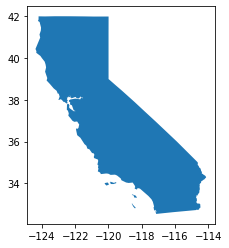

In [4]:
ca_poly = gpd.read_file('bnds/California.shp')
ax = ca_poly.plot() # plot the boundary file of California

In [5]:
ca_poly.crs  # Lists the coordinate reference system (crs)

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [6]:
xy_nad83 = ca_poly.bounds #store the bounds of the shape file
xy_nad83

,minx,miny,maxx,maxy
0,-124.392638,32.535781,-114.12523,42.002191


As we see above, the boundary file is in the `EPSG:4269` coordinate system.  This differs from `EPSG:4326` only by the datum. We'll see below that differences will be very minor but the process is the same for any file not in EPSG:4326.  

### Geographic Bounding Box - for searching NASA Earthdata CMR Metadata
* we'll determine and store, as a python list, the geographic bounding box of the California shape file
* data can be reprojected using the **`GeoDataFrame.to_crs()`** command.

In [7]:
ca_poly_4269 = ca_poly.to_crs(epsg=4326)
xy_wgs84 = ca_poly_4269.bounds # bound of polygon in WGS84
xy_wgs84 = ca_poly_4269.bounds.values.tolist()[0] # We'll save this as a Python list to serve as a subsetting parameter
print(xy_wgs84)

[-124.39263575019409, 32.53578253612507, -114.1252281747415, 42.002192463378705]


### Lambert Conformal Conic bounding box - Daymet's CRS - for subsetting the file using OPeNDAP protocols

* Again, using **`GeoDataFrame.to_crs()`**, we'll project the polygon geopanda object (`ca_poly`) to LCC
* Daymet is natively in a `lambert_conformal_conic (LCC)` projection.  
- We'll present two examples to obtain the LCC paramters used to project the California bounding box to LCC.

### Example 1:  Daymet's LCC Projection
Use a Daymet file and **`rioxarray`** to obtain the LCC projection parameters

In [8]:
# Obtain the Daymet LCC projection parameters from a Daymet file
daymet_x = xr.open_dataset('daymet_v4_tmax_annavg_pr_1950.nc',  decode_coords="all")
daymet_x.rio.crs
daymet_x_proj = daymet_x.rio.crs

# Project the California polygon to LCC
ca_poly_lcc_1 = ca_poly.to_crs(daymet_x_proj) # to_crs re-projects from 4269 to LCC
print(ca_poly_lcc_1.crs.coordinate_operation.to_wkt(pretty=False))

CONVERSION["unnamed",METHOD["Lambert Conic Conformal (2SP)",ID["EPSG",9802]],PARAMETER["Latitude of 1st standard parallel",25,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8823]],PARAMETER["Latitude of 2nd standard parallel",60,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8824]],PARAMETER["Latitude of false origin",42.5,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8821]],PARAMETER["Longitude of false origin",-100,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8822]],PARAMETER["Easting at false origin",0,LENGTHUNIT["metre",1],ID["EPSG",8826]],PARAMETER["Northing at false origin",0,LENGTHUNIT["metre",1],ID["EPSG",8827]]]


### Example 2:  Daymet's LCC Projection
The Daymet LCC projection parameters are found presented as a `Proj.4 String` in the Daymet [User Guide](https://daac.ornl.gov/DAYMET/guides/Daymet_Daily_V4R1.html).

<div class="alert alert-block alert-info">
PROJ.4: +proj=lcc +ellps=WGS84 +a=6378137 +b=6356752.314245 +lat_1=25 +lat_2=60 +lon_0=-100 +lat_0=42.5 +x_0=0 +y_0=0 +units=m +no_defs
</dev>

In [9]:
# Define the Daymet projection using the Proj.4 String
daymet_proj = "+proj=lcc +ellps=WGS84 +a=6378137 +b=6356752.314245 +lat_1=25 +lat_2=60 +lon_0=-100 +lat_0=42.5 +x_0=0 +y_0=0 +units=m +no_defs"
# Project the California polygon to LCC 
ca_poly_lcc_2 = ca_poly.to_crs(daymet_proj) # to_crs re-projects from 4269 to LCC


### Save the CA Bounding Box in LCC Projection

In [10]:
lccbounds = ca_poly_lcc_1.bounds # Bounds in LCC projection
print('')
print('Projected bounding box of the California polygon file in LCC projection')
lccbounds.round(2)


Projected bounding box of the California polygon file in LCC projection


,minx,miny,maxx,maxy
0,-1949774.11,-924691.39,-1249285.39,222385.26


### Plot the California Shape Files

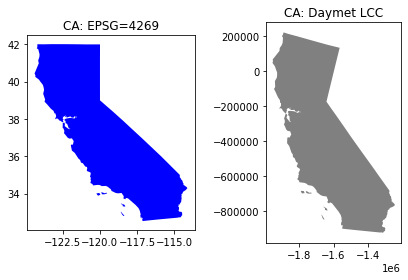

In [11]:
# plot the CA polygon in EPSG:4269 and the Lambert Conformal Conic projection
%matplotlib inline
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6, 4))
ca_poly.plot(ax=ax1, facecolor='blue');
ax1.set_title("CA: EPSG=4269");
ca_poly_lcc_2.plot(ax=ax2, facecolor='grey');
ax2.set_title("CA: Daymet LCC");
plt.tight_layout()

## 1.2 Temporal: Search and Subset Parameters
### Set and format a time range of interest to discover and subset data

For this example, we'll access 1 year of Daymet daily data.

In [12]:
import datetime as dt 

start_date = dt.datetime(2010, 1, 1) # specify your own start date
end_date = dt.datetime(2011, 12, 31)  # specify your end start date
print(start_date,end_date,sep='\n')

dt_format = '%Y-%m-%dT%H:%M:%SZ' # format requirement for datetime search
temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)
print(temporal_str)

2010-01-01 00:00:00
2011-12-31 00:00:00
2010-01-01T00:00:00Z,2011-12-31T00:00:00Z


----
----

## STEP 2. Finding Data Files of Interest : NASA's CRM API

If you know the OPeNDAP URL's for your data of interest, you can skip this step.

In this step, we'll leverage NASA's Common Metadata Repository (CMR) API to search NASA Earthdata for Daymet data that are within a spatial and temporal region of interest.  

If you search [NASA's Earthdata Search](https://search.earthdata.nasa.gov/search) for [Daymet Daily data](https://search.earthdata.nasa.gov/search?q=daymet%20daily), you'll find about 1,000 files associated with the most recent version of that dataset.  

In STEP 1, we defined a spatial and temporal area-of-interest. We'll see how we can programatically use those as a search parameters to discover which specific Daymet daily data files are within NASA Earthdata holdings that match those parameters.  

**At the end of this step, we will have a list of Daymet files that are within our search parameters (spatial and temporal)**

* **This methodology can be applied to any NASA Earthdata Dataset**

A little backgroud ....

- Searching [NASA's Earthdata Holdings](https://search.earthdata.nasa.gov/search) can lead to quite a few files for a user to consider. 
![title](images/NASAEarthdataCollectionSearch_narrow_LI.jpg.PNG)
<br>

Some helpful links:
- NASA has a metadata system that catalogs all data and metadata records:  [Common Metadata Repository (CMR)](https://earthdata.nasa.gov/eosdis/science-system-description/eosdis-components/cmr) 

- Using the [CMR API](https://cmr.earthdata.nasa.gov/search), we can search metadata records to discovered data granules (files).


**`Request URL's`**
<div class="alert alert-block alert-info">
https://cmr.earthdata.nasa.gov/search/collections
</div>

<div class="alert alert-block alert-info">
https://cmr.earthdata.nasa.gov/search/granules
</div>

- The [Daymet V4R1 Daily](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=2129) data DOI, **`doi.org/10.3334/ORNLDAAC/2129`**.

## Finding Data Files in NASA's EarthData Cloud: or What's a ConceptID

NASA Earthdata holds thousands of datasets and finding the files that fit within a spatial area of interest and time frame can be quite daunting.  
* We'll demonstrate how to use NASA's [**CMR API**](https://cmr.earthdata.nasa.gov/search) and either the Daymet dataset `DOI` or the `shortname` to obtain the NASA EarthData's unique ID (called the **`Concept ID`**) for **Daymet Daily** data.  With this information, we can search all of NASA's Earthdata holdings for matching data files (granules) based on our spatial area and time period of interest.

Search NASA Earthdata Holdings based on...
* *`DOI`* - The Daymet daily data Digital Object Identifier
* *`ConceptID`* - remember, this is NASA Earthdata's unique ID for this dataset
* Area of Interest
* Time Range of Interest

## Step 2.1 Obtaining the Daymet V4 Daily data *Concept ID*
Using Python's **`requests`** library, we will build and provide the URL `doisearch` to search **NASA's Common Metadata Repository (CMR)** to acquire the **`concept_id`** unique to the Daymet V4 Daily data in NASA's Cloud holdings.  We'll use the **concept_id** in a next step when we search NASA Cloud Holdings for our spatial and temporal area of interest.

*  We're going to build a **CMR URL** for the Daymet V4R1 Daily Data
* **`requests`** is a simple HTTP libray for Python.  It allows you to easily send HTTP requests

<div class="alert alert-block alert-info">
https://cmr.earthdata.nasa.gov/search/collections
</div>

* Basically, we're going to programmatically build the CMR URL for the Daymet Daily data and search for and store the ConceptID
`https://cmr.earthdata.nasa.gov/search/collections.json?doi=10.3334/ORNLDAAC/2129`





In [13]:
# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/' # define the base url of NASA's CMR API as the variable `cmrurl`
doi = '10.3334/ORNLDAAC/2129'                   # Daymet V4R1 DOI - define the DOI as the variable `daymet_doi`
doisearch = cmrurl + 'collections.json?doi=' + doi
print(doisearch)

import requests
concept_id = requests.get(doisearch).json()['feed']['entry'][0]['id']
print(concept_id)

https://cmr.earthdata.nasa.gov/search/collections.json?doi=10.3334/ORNLDAAC/2129
C2532426483-ORNL_CLOUD


**`C2532426483-ORNL_CLOUD`** is the unique NASA-given concept ID for the Daymet daily dataset. We can use this to search relevant granules and their names. 

- Another way to get to the Daymet ConceptID from CMR's Collection's URL `https://cmr.earthdata.nasa.gov/search/collections.json` and knowing the shortname `Daymet_Daily_V4R1_2129`

In [14]:
params = {
    'short_name': 'Daymet_Daily_V4R1_2129',
} # parameter dictionary with known CMR short_name

cmr_collections_url = 'https://cmr.earthdata.nasa.gov/search/collections.json'
cmr_response = requests.get(cmr_collections_url, params=params)
print(cmr_response)
cmr_results = json.loads(cmr_response.content) # Get json response from CMR collection metadata
#print(cmr_results)
collectionlist = [el['id'] for el in cmr_results['feed']['entry']]
print(collectionlist)
concept_id = collectionlist[0]
print(concept_id)

<Response [200]>
['C2532426483-ORNL_CLOUD']
C2532426483-ORNL_CLOUD


## Step 2.2 Searching for Daymet Files 
Daymet daily data files (or granules) are in netCDF4 format, and each file has one year's worth of data. Data files are organized by variables (each for dayl, prcp, tmin, tmax, srad, swe, vp) and regions (each for us, pr, hi).  Daymet filenames can be used to identify the files from continental North America (`*_na_*.nc`). The files from Puerto Rico and Hawaii are named as (`*_pr_*.nc`) and (`*_hi_*.nc`) respectively.

<div class="alert alert-block alert-info">
https://cmr.earthdata.nasa.gov/search/granules
</div>

We will first search all the granules for our area (i.e., California) and time period of interest (2010, 2011).  For this tutorial, we set up the search parameters and download maximum temperature data (`tmax`).

In [15]:
#var = 'prcp' # select your own variable
var = 'tmax' # select your own variable

print('Variables we have defined to pass to the CMR API')
print('-----------------------------------------------')
print('time range :     ', temporal_str)
print('Daymet variable :', var)
print('bounding box :   ', xy_wgs84)
print('concept ID :     ', concept_id)
print('cmr url :        ', cmrurl)

Variables we have defined to pass to the CMR API
-----------------------------------------------
time range :      2010-01-01T00:00:00Z,2011-12-31T00:00:00Z
Daymet variable : tmax
bounding box :    [-124.39263575019409, 32.53578253612507, -114.1252281747415, 42.002192463378705]
concept ID :      C2532426483-ORNL_CLOUD
cmr url :         https://cmr.earthdata.nasa.gov/search/


### Here, we're building the CMR URL for the files (granules) that match our parameters of interest.

In [16]:
granulesearch = cmrurl + 'granules.json?collection_concept_id=' + concept_id + \
                '&page_size=1000' + '&temporal=' + temporal_str + \
                '&bounding_box[]=' + ','.join(map(str, xy_wgs84))
print(granulesearch)                

https://cmr.earthdata.nasa.gov/search/granules.json?collection_concept_id=C2532426483-ORNL_CLOUD&page_size=1000&temporal=2010-01-01T00:00:00Z,2011-12-31T00:00:00Z&bounding_box[]=-124.39263575019409,32.53578253612507,-114.1252281747415,42.002192463378705


### Searching NASA's Earthdata holdings and getting a list of files that match our parameters
Now, we'll get a list of files using Python's **`requests`** library. We can provide the URL created above, `granulesearch`, created above to search **NASA's Earthdata Metadata** holdings for Daymet data that fit our spatial, temporal, and variable request.

In [17]:
response = requests.get(granulesearch)
granules = response.json()['feed']['entry']  
granule_names = []
for g in granules:
    granule_name = g['title']
    if var in granule_name:
        granule_names.append(granule_name)
        print(granule_name)

Daymet_Daily_V4R1.daymet_v4_daily_na_tmax_2010.nc
Daymet_Daily_V4R1.daymet_v4_daily_na_tmax_2011.nc


The array `granule_names` contains the names of all the granules (files) that match our search parameters.

**Note:** A typical Daymet V4 daily file has the name **daymet_v4_daily_`area`_`var`_`year`.nc**.  The beginning of the filename (**"Daymet_Daily_V4R1."**) is specific to the cloud-based naming convention and because we are searching CMR, the cloud-based files will be discovered.  

## STEP 3. Subsetting data from NASA Earthdata Cloud

Using the granule list we programmatically obtained above, we'll subset the North American files to our area of interest using the bounding box from the California polygon.

Daymet data is available through NASA's EarthData Cloud *`Hyrax Data Server`*.

For example ...

[Daymet V4R1 Daily Data in the NASA Earthdata Cloud Hyrax Data Server](https://opendap.earthdata.nasa.gov/collections/C2532426483-ORNL_CLOUD/granules/Daymet_Daily_V4R1.daymet_v4_daily_na_tmax_2010.nc.dmr.html)

### **`OPeNDAP`** allows users to use data files that are stored on remote computers with their favorite analysis and visualization client software.

NASA Earthdata has great informaion on OPeNDAP: [What is OPeNDAP](https://earthdata.nasa.gov/collaborate/open-data-services-and-software/api/opendap)

###  We'll use Pythons **`pydap`** library

* **[pydap](https://www.pydap.org/en/latest/client.html)** also **[pydap](https://github.com/pydap/pydap)** can be used to inspect data from any scientific dataset available on the internet from OPeNDAP servers. This allows inspection and manipulation of scientific data as if it were stored locally.  Data can be downloaded on-the-fly as needed.

###  We'll use Python's **`Xarray`** Library to 
* open the data files we are searching for, 
* subset the North American file based on the Lambert Conformal Conic **`lccbounds`** bounding box we defined earlier, 
* concatenate the time range of files into one file, and 
* save the concatened file to a netCDF file.

Pydap
* **open_url**

Xarray
* **[open_dataset](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html)** 
* **slice**
* **concat**
* **to_netcdf**

We will subset and download Daymet V4 Daily Data based on
- **`granual_names`** array we saved above 
- our polygonal region of interest (LCC bounding box)
- our time range of interest
- Daymet variable

###  A NASA Earthdata Login is required
Get an account here https://urs.earthdata.nasa.gov/

- We'll use the Central Authentication Service (CAS) as a single sign-on protocol for the web.
- NASA Earthdata Authenticaion is done through `username` and `login`

In [19]:
# THIS IS ACCESSING DAYMET DAILY DATA in NGAP HYDRAX via OPeNDAP.  
# for loop based on response granules: granule_names  

from pydap.client import open_url
from pydap.cas.urs import setup_session
import xarray as xr
import time

username = "YourEarthdataLogin_UserName" # Earthdata URS Login (only needed for NGAP Hyrax) Get account here https://urs.earthdata.nasa.gov/
password= "YourEarthdataLogin_pw"

hyrax_url = 'https://opendap.earthdata.nasa.gov/collections/C2532426483-ORNL_CLOUD/granules/'

session = setup_session(username, password, check_url=hyrax_url)  

before = time.time()
cnt = 0 
for g_name in granule_names:
    print('granule_name ---->', g_name)
    granule_dap = hyrax_url + g_name 
    print(granule_dap)
    
    hyrax_ds = open_url(granule_dap, session=session)
    print('hyrax_ds ----->', hyrax_ds)
    ds = xr.open_dataset(xr.backends.PydapDataStore(hyrax_ds), decode_coords="all")
    print(ds)
    
    #tmax_sel=ds['tmax'].sel(x=slice(lccbounds.minx[0],lccbounds.maxx[0]), y=slice(lccbounds.maxy[0],lccbounds.miny[0]))
    tmax_sel=ds['tmax'].sel(x=slice(1386957,1470587), y=slice(-565105,-612937)) #GSMNP boundary
    #print(tmax_sel)
    if cnt==0:
        tmax_h = tmax_sel
        print('tmax_h ====')
        print(tmax_h)
        #tmax_h.to_netcdf('test.nc')
    else:
        #print('elsey')
        tmax_h = xr.concat([tmax_h, tmax_sel], dim="time")
    
    cnt += 1

print('concat tmax_h ----->', tmax_h)    
# save to netcdf
#tmax_h.to_netcdf(var + '_cali_hyrax_subset.nc')
print("Processing Time: ", time.time() - before, 'seconds')

granule_name ----> Daymet_Daily_V4R1.daymet_v4_daily_na_tmax_2010.nc
https://opendap.earthdata.nasa.gov/collections/C2532426483-ORNL_CLOUD/granules/Daymet_Daily_V4R1.daymet_v4_daily_na_tmax_2010.nc
hyrax_ds -----> <DatasetType with children 'y', 'lon', 'lambert_conformal_conic', 'time', 'yearday', 'tmax', 'lat', 'time_bnds', 'x'>


C:\Programs\Anaconda\envs\hyrax_daymet\lib\site-packages\pydap\handlers\dap.py:397: RuntimeWarning: overflow encountered in int_scalars
  count = response_dtype.itemsize * n
C:\Programs\Anaconda\envs\hyrax_daymet\lib\site-packages\pydap\handlers\dap.py:397: RuntimeWarning: overflow encountered in int_scalars
  count = response_dtype.itemsize * n


<xarray.Dataset>
Dimensions:                  (y: 8075, x: 7814, time: 365, nv: 2)
Coordinates:
  * y                        (y) float32 4.984e+06 4.983e+06 ... -3.09e+06
    lon                      (y, x) float32 ...
    lambert_conformal_conic  int16 ...
  * time                     (time) datetime64[ns] 2010-01-01T12:00:00 ... 20...
    lat                      (y, x) float32 ...
    time_bnds                (time, nv) datetime64[ns] ...
  * x                        (x) float32 -4.56e+06 -4.559e+06 ... 3.253e+06
Dimensions without coordinates: nv
Data variables:
    yearday                  (time) int16 ...
    tmax                     (time, y, x) float32 ...
Attributes:
    build_dmrpp_metadata.build_dmrpp:    3.20.10-462
    build_dmrpp_metadata.bes:            3.20.10-462
    build_dmrpp_metadata.libdap:         libdap-3.20.9-84
    build_dmrpp_metadata.configuration:  \n# TheBESKeys::get_as_config()\nAll...
    build_dmrpp_metadata.invocation:     build_dmrpp -c /tmp/bes_conf_

C:\Programs\Anaconda\envs\hyrax_daymet\lib\site-packages\pydap\handlers\dap.py:397: RuntimeWarning: overflow encountered in int_scalars
  count = response_dtype.itemsize * n
C:\Programs\Anaconda\envs\hyrax_daymet\lib\site-packages\pydap\handlers\dap.py:397: RuntimeWarning: overflow encountered in int_scalars
  count = response_dtype.itemsize * n


<xarray.Dataset>
Dimensions:                  (y: 8075, x: 7814, time: 365, nv: 2)
Coordinates:
  * y                        (y) float32 4.984e+06 4.983e+06 ... -3.09e+06
    lon                      (y, x) float32 ...
    lambert_conformal_conic  int16 ...
  * time                     (time) datetime64[ns] 2011-01-01T12:00:00 ... 20...
    lat                      (y, x) float32 ...
    time_bnds                (time, nv) datetime64[ns] ...
  * x                        (x) float32 -4.56e+06 -4.559e+06 ... 3.253e+06
Dimensions without coordinates: nv
Data variables:
    yearday                  (time) int16 ...
    tmax                     (time, y, x) float32 ...
Attributes:
    build_dmrpp_metadata.build_dmrpp:    3.20.10-462
    build_dmrpp_metadata.bes:            3.20.10-462
    build_dmrpp_metadata.libdap:         libdap-3.20.9-84
    build_dmrpp_metadata.configuration:  \n# TheBESKeys::get_as_config()\nAll...
    build_dmrpp_metadata.invocation:     build_dmrpp -c /tmp/bes_conf_

C:\Programs\Anaconda\envs\hyrax_daymet\lib\site-packages\pydap\handlers\dap.py:397: RuntimeWarning: overflow encountered in int_scalars
  count = response_dtype.itemsize * n
C:\Programs\Anaconda\envs\hyrax_daymet\lib\site-packages\pydap\handlers\dap.py:397: RuntimeWarning: overflow encountered in int_scalars
  count = response_dtype.itemsize * n


ValueError: buffer size must be a multiple of element size

In [ ]:
# SKIP THIS - TESTING WITH ONE SLICE
# THIS IS ACCESSING DAYMET DAILY DATA in NGAP HYDRAX via OPeNDAP.  
# for loop based on response granules eg.) Daymet_Daily_V4.daymet_v4_daily_na_tmax_2010.nc, Daymet_Daily_V4.daymet_v4_daily_na_tmax_2011.nc 

from pydap.client import open_url
from pydap.cas.urs import setup_session
import xarray as xr
import time

username = "mthornton" # Earthdata URS Login (only needed for NGAP Hyrax) Get account here https://urs.earthdata.nasa.gov/
password= "Earthdata4Michele"

hyrax_url = 'https://opendap.earthdata.nasa.gov/collections/C2532426483-ORNL_CLOUD/granules/'

session = setup_session(username, password, check_url=hyrax_url)  

before = time.time()
cnt = 0 
for g_name in granule_names:
    print('granule_name ---->', g_name)
    #granule_dap = thredds_url + g_name.replace('Daymet_Daily_V4R1.','') #The name suffix is needed for cloud file name, not here for TDS
    granule_dap = hyrax_url + g_name 
    print(granule_dap)
    
    hyrax_ds = open_url(granule_dap, session=session)
    ds = xr.open_dataset(xr.backends.PydapDataStore(hyrax_ds), decode_coords="all")
    
    subset=ds['tmax'].sel(x=slice(lccbounds.minx[0],lccbounds.maxx[0]), y=slice(lccbounds.maxy[0],lccbounds.miny[0]))
    print(subset)
    #dummy=ds['tmax'].sel(x=slice(1386957,1470587), y=slice(-565105,-612937))
    subset.to_netcdf(g_name.replace('Daymet_Daily_V4R1.','CAsubset_'))
    #subset.to_netcdf(CA_test)
    
    #if cnt==0:
    #    tmax_h = dummy
    #else:
    #    tmax_h = xr.concat([tmax_h, dummy], dim="time")
    
    #cnt += 1

# save to netcdf
#tmax_h.to_netcdf(var + '_cali_hyrax_subset.nc')
#granule_name ----> Daymet_Daily_V4.daymet_v4_daily_na_tmax_2010.nc
#subset.to_netcdf(g_name.replace('Daymet_Daily_V4R1.','CAsubset_'))
print("Processing Time: ", time.time() - before, 'seconds')

In [ ]:
# THIS IS ACCESSING DAYMET DAILY DATA in NGAP HYDRAX via OPeNDAP.  
# for loop based on response granules eg.) Daymet_Daily_V4.daymet_v4_daily_na_tmax_2010.nc, Daymet_Daily_V4.daymet_v4_daily_na_tmax_2011.nc 

from pydap.client import open_url
from pydap.cas.urs import setup_session
import xarray as xr
import time

username = "mthornton" # Earthdata URS Login (only needed for NGAP Hyrax) Get account here https://urs.earthdata.nasa.gov/
password= "Earthdata4Michele"

hyrax_url = 'https://opendap.earthdata.nasa.gov/collections/C2532426483-ORNL_CLOUD/granules/'

session = setup_session(username, password, check_url=hyrax_url)  

before = time.time()
cnt = 0 
for g_name in granule_names:
    print('granule_name ---->', g_name)
    #granule_dap = thredds_url + g_name.replace('Daymet_Daily_V4R1.','') #The name suffix is needed for cloud file name
    granule_dap = hyrax_url + g_name 
    print(granule_dap)
    
    hyrax_ds = open_url(granule_dap, session=session)
    ds = xr.open_dataset(xr.backends.PydapDataStore(hyrax_ds), decode_coords="all")
    print(ds)
    
    dummy=ds['tmax'].sel(x=slice(lccbounds.minx[0],lccbounds.maxx[0]), y=slice(lccbounds.maxy[0],lccbounds.miny[0]))
    print('dummy')
    print(dummy)
    #dummy=ds['prcp'].sel(x=slice(1386957,1470587), y=slice(-565105,-612937))
    if cnt==0:
        tmax_h = dummy
        print('tmax_h ====')
        print(tmax_h)
        tmax_h.to_netcdf('test.nc')
    else:
        tmax_h = xr.concat([tmax_h, dummy], dim="time")
    
    cnt += 1

print(tmax_h)    
# save to netcdf
tmax_h.to_netcdf(var + '_cali_hyrax_subset.nc')
print("Processing Time: ", time.time() - before, 'seconds')

In [ ]:
tmax_h

In [ ]:
import matplotlib.pyplot as plt
tmax = tmax_h.isel(time=200) # isel = xarray index selection (python index start from 0, so day 7) 
ax = plt.subplot()
tmax.plot(ax=ax, robust=True)
# Note xarray uses dimension and attribute information image - time:2010-01-07, projection is recognized

##### Let's take a look at the Daymet Temperature Subset for 2011

In [ ]:
#subset

In [ ]:
###SKIP THIS
import matplotlib.pyplot as plt
#tmax_ca = subset.isel(time=6) # isel = xarray index selection (python index start from 0, so day 7) 
tmax_ca = tmax_h.isel(time=6) # isel = xarray index selection (python index start from 0, so day 7) 
ax = plt.subplot()
tmax_ca.plot(ax=ax, robust=True)
# Note xarray uses dimension and attribute information image - time:2010-01-07, projection is recognized

In [ ]:
import matplotlib.pyplot as plt
tmax_ca = tmax_h.isel(time=6)
fig, ax = plt.subplots(figsize = (20,10))
tmax_ca.plot(ax=ax, robust=True, cbar_kwargs={'label': 'degrees C'})
ca_poly_lcc_1.plot(ax = ax, color = 'none', edgecolor = 'red')

### Step 4. Clipping the subset area by polygon
In this step, we demonstrate how to clip the subset to our polygon of interest.  We'll use Python's *rasterio* library.

* **`rasterio`** provides many capabilities found in GDAL

First, we'll map the subset precipitation data matrix to real world coordinates using the **'translation'** and **'scale'** methods of **'Affine'**.

In [ ]:
from rasterio.features import Affine
res = 1000 # daymet spatial resolution is 1km x 1km
#transform = Affine.translation(min(subset.x).values - res / 2, min(subset.y).values - res / 2) * Affine.scale(res, res)
transform = Affine.translation(min(tmax_h.x).values - res / 2, min(tmax_h.y).values - res / 2) * Affine.scale(res, res)
transform

In [ ]:
from rasterio.features import geometry_mask
#ca_mask = geometry_mask(ca_poly_lcc_1.geometry, out_shape=(len(subset.y), len(subset.x)), transform=transform, invert=True)
ca_mask = geometry_mask(ca_poly_lcc_1.geometry, out_shape=(len(tmax_h.y), len(tmax_h.x)), transform=transform, invert=True)
polymask = xr.DataArray(ca_mask , dims=("y", "x"))
polymask = polymask.sel(y=slice(None, None, -1)) 
tmax_masked = tmax_h.where(polymask == True)
# write out to a netCDF file
tmax_masked.to_netcdf(var + '_subset_poly.nc')

Now let's plot the subset for the day

In [ ]:
##SKIP THIS
import matplotlib.pyplot as plt
tmax_1 = tmax_masked.isel(time=6)
ax = plt.subplot()
tmax_1.plot(ax=ax, cmap="turbo", cbar_kwargs={'label': 'degrees C'})

In [ ]:
import matplotlib.pyplot as plt
tmax_1 = tmax_masked.isel(time=6)
fig, ax = plt.subplots(figsize = (20,10))
tmax_1.plot(ax=ax, robust=True, cmap="turbo", cbar_kwargs={'label': 'degrees C'})
ca_poly_lcc_1.plot(ax = ax, color = 'none', edgecolor = 'red')

#### Saving to a GeoTIFF
The subset data can also be clipped by a polygon of interest and converted to GeoTiff using the rioxarray and shapely libraries.

* **`rioxarray`** is an extention of xarray.  It can be used to clip, merge, and reproject rasters
* **`shapely`** is a Python package for manipulation and analysis of planar geometery objects

In [ ]:
import rioxarray
from shapely.geometry import mapping
print(var)

#prcp_sub = rioxarray.open_rasterio(var + '_subset_poly.nc', decode_coords="all")
#tmax_sub = rioxarray.open_rasterio(var + '_tdssubset.nc', decode_coords="all", decode_times=False)

#tmax_sub = rioxarray.open_rasterio(var + '_subset_poly.nc', decode_coords="all", decode_times=False)
tmax_sub = rioxarray.open_rasterio(var + '_cali_hyrax_subset.nc', masked=True)
tmax_clip = tmax_sub.tmax.rio.clip(ca_poly_lcc_1.geometry.apply(mapping), ca_poly_lcc_1.crs, invert=False, from_disk=True)

# saving one time step to geotiff
tmax_clip_day6 = tmax_clip.isel(time=6)
tmax_clip_day6.rio.to_raster("tmax_clip_day6.tif")